In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import seaborn as sns
import networkx as nx
from sklearn.metrics import accuracy_score, roc_auc_score


# A Simple Backdoor Path - and some equations that it might represent

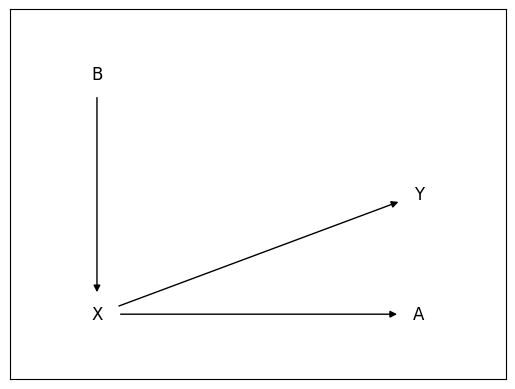

In [11]:
plt.margins(x = 0.2, y = 0.2)

G = nx.DiGraph()

G.add_edges_from([('X', 'Y'), ('X', 'A'), ('B', 'X')])

fixed_positions = {'X': (0, 0), 'Y': (3, 3), 'A': (3, 0), 'B': (0, 6)}

nx.draw_networkx(G, with_labels = True, node_color = 'white', node_size = 1000, font_color = 'black', pos = fixed_positions)

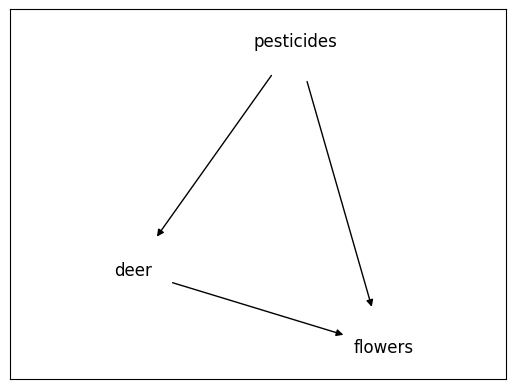

In [146]:
# create a directed graph
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('pesticides', 'deer'),\
                  ('pesticides', 'flowers'),\
                  ('deer', 'flowers'),\
                 ])

# fix the positions of all three nodes
fixed_positions = {'pesticides':(1.3,2),\
                   'deer':(0,0.5), \
                   'flowers':(2,0)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000, \
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [188]:
# Linear relationship
num = 100
Z_pesticides = np.maximum(np.random.normal(3, 1, num), 0)
X_deer = np.maximum(np.random.normal(8, 2, num) - Z_pesticides, 0)
Y_flowers = np.maximum(20 - Z_pesticides - X_deer + np.random.normal(0, 1, num), 0)

In [189]:
df = pd.DataFrame({"X_deer": X_deer})

In [190]:
results = sm.OLS(Y_flowers, sm.add_constant(df)).fit()
results.params

const     15.759906
X_deer    -0.772923
dtype: float64

In [191]:
df2 = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides})

In [192]:
results = sm.OLS(Y_flowers, sm.add_constant(df2)).fit()
results.params

const           20.104526
X_deer          -1.006645
Z_pesticides    -1.025825
dtype: float64

### Interaction term

In [193]:
num = 10000
Z_pesticides = np.maximum(np.random.normal(3, 1, num), 0)
X_deer = np.maximum(np.random.normal(8, 2, num) - Z_pesticides, 0)
Y_flowers_int = np.maximum(20 - Z_pesticides - X_deer + 0.2 * Z_pesticides * X_deer + np.random.normal(0, 1, num), 0)

In [194]:
df = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides})
results = sm.OLS(Y_flowers_int, sm.add_constant(df)).fit()
results.params

const           16.853121
X_deer          -0.403854
Z_pesticides    -0.010752
dtype: float64

In [195]:
df_int = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides, "X_Z": X_deer * Z_pesticides})
results = sm.OLS(Y_flowers_int, sm.add_constant(df_int)).fit()
results.params

const           19.913088
X_deer          -0.980992
Z_pesticides    -0.969849
X_Z              0.193297
dtype: float64

### Nonlinear (Logistic) regression

In [204]:
num = 10000
Z_pesticides = np.maximum(np.random.normal(3, 1, num), 0)
X_deer = np.maximum(np.random.normal(8, 2, num) - Z_pesticides, 0)
true_prob_flowers_lr = 1 / (1 + np.exp(-(4 - 0.5 * Z_pesticides - 0.5 * X_deer)))
Y_flowers_lr = np.random.binomial(1, true_prob_flowers_lr)

In [205]:
df_lr = pd.DataFrame({"X_deer": X_deer, "Z_pesticides": Z_pesticides})
results = sm.OLS(Y_flowers_lr, sm.add_constant(df_lr)).fit()
results.params

const           1.329019
X_deer         -0.104666
Z_pesticides   -0.102926
dtype: float64

In [206]:
np.corrcoef(results.predict(sm.add_constant(df_lr)), Y_flowers_lr)

array([[1.        , 0.41509308],
       [0.41509308, 1.        ]])

In [207]:
results = sm.Logit(Y_flowers_lr, sm.add_constant(df_lr)).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.598663
         Iterations 5


const           4.003997
X_deer         -0.505131
Z_pesticides   -0.498942
dtype: float64

In [219]:
probs = results.predict(sm.add_constant(df_lr))
preds = 1 * (probs > 0.5)
np.corrcoef(probs, Y_flowers_lr)

array([[1.        , 0.41731643],
       [0.41731643, 1.        ]])

In [220]:
print(accuracy_score(Y_flowers_lr, preds))
print(roc_auc_score(Y_flowers_lr, probs))

0.6737
0.7397158772926791


# A backdoor path: we can control for any item in the path

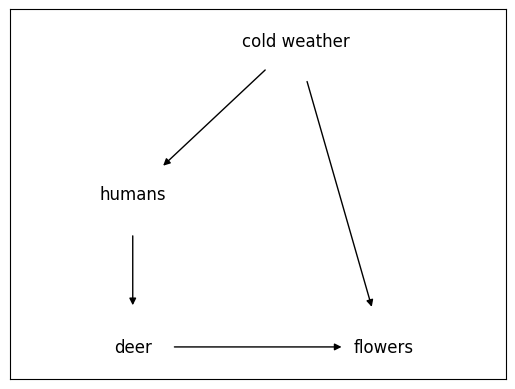

In [221]:
# create a directed graph
# This time, cold weather kills flowers.  Cold weather also chases humans away, which invites deer to return.
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('humans', 'deer'),\
                  ('cold weather', 'humans'),\
                  ('cold weather', 'flowers'),\
                  ('deer', 'flowers'),\
                 ])

# fix the positions of all three nodes
fixed_positions = {'cold weather':(1.3,2),\
                   'humans':(0,1),\
                   'deer':(0,0), \
                   'flowers':(2,0)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [12]:
num = 10000
W_temp = np.random.normal(50, 10, num)
W_humans = 100 - W_temp + np.random.normal(0, 5, num)
X_deer = 150 - W_humans + np.random.normal(0, 10, num)
Y_flowers = 20 + W_temp - 0.3 * X_deer + np.random.normal(0, 5, num)
df = pd.DataFrame({"W_temp": W_temp, "W_humans": W_humans, "X_deer": X_deer, "Y_flowers": Y_flowers})

In [13]:
df.corr()

,W_temp,W_humans,X_deer,Y_flowers
W_temp,1.000000,-0.893976,0.670381,0.760418
W_humans,-0.893976,1.000000,-0.744811,-0.603757
X_deer,0.670381,-0.744811,1.000000,0.241612
Y_flowers,0.760418,-0.603757,0.241612,1.000000


In [14]:
# Find effect of deer on flowers - no control
results = sm.OLS(Y_flowers, sm.add_constant(df[["X_deer"]])).fit()
results.params

const     25.067525
X_deer     0.149198
dtype: float64

In [15]:
# Find effect of deer on flowers - control for humans 
results = sm.OLS(Y_flowers, sm.add_constant(df[["X_deer", "W_humans"]])).fit()
results.params

const       108.051970
X_deer       -0.288567
W_humans     -0.783755
dtype: float64

In [16]:
# Find effect of deer on flowers - control for temp 
results = sm.OLS(Y_flowers, sm.add_constant(df[["X_deer", "W_temp"]])).fit()
results.params

const     19.835312
X_deer    -0.300749
W_temp     1.005182
dtype: float64

# Two Front Door Paths: not necessary to control for either

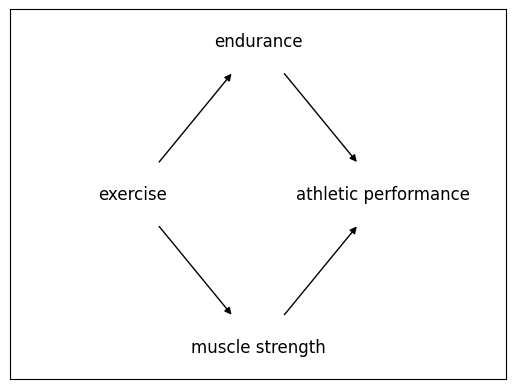

In [226]:
# create a directed graph
# This time, cold weather kills flowers.  Cold weather also chases humans away, which invites deer to return.
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('exercise', 'muscle strength'),\
                  ('muscle strength', 'athletic performance'),\
                  ('exercise', 'endurance'),\
                  ('endurance', 'athletic performance'),\
                 ])
                  #('social_media_usage', 'creativity')])

# fix the positions of all three nodes
fixed_positions = {'exercise':(0, 0.5),\
                   'muscle strength':(0.5,0),\
                   'endurance':(0.5,1), \
                   'athletic performance':(1,0.5)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [233]:
num = 10000
X_exercise = np.random.normal(10, 2, num)
A_endurance = np.maximum(0.5 * X_exercise + np.random.normal(0, 1, num), 0)
B_muscle = np.maximum(2 * X_exercise + np.random.normal(0, 1, num), 0)
Y_performance = 2 + A_endurance + B_muscle + np.random.normal(0, 1, num)
df = pd.DataFrame({"X_exercise": X_exercise})

In [234]:
results = sm.OLS(Y_performance, sm.add_constant(df)).fit()
results.params

const         2.028895
X_exercise    2.498400
dtype: float64

In [235]:
df_wrong = pd.DataFrame({"X_exercise": X_exercise, "A_endurance": A_endurance, "B_muscle": B_muscle})
results = sm.OLS(Y_performance, sm.add_constant(df_wrong)).fit()
results.params

const          2.022124
X_exercise    -0.020451
A_endurance    1.008774
B_muscle       1.006858
dtype: float64

# Collider: we should not control for it

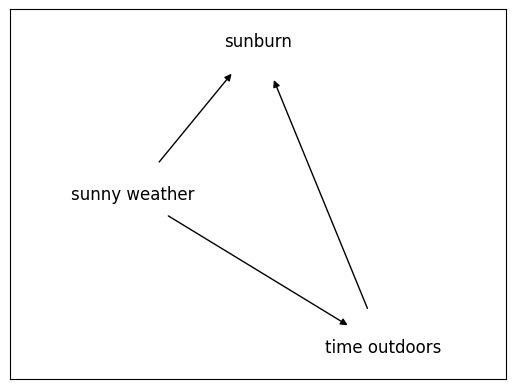

In [236]:
# create a directed graph
# https://medium.com/@whystudying/causal-inference-with-python-causal-graphs-ef2f3a52c266
plt.margins(x = 0.4)

G = nx.DiGraph()

# add edges from a list of tuples
G.add_edges_from([('sunny weather', 'sunburn'),\
                  ('time outdoors', 'sunburn'),\
                  ('sunny weather', 'time outdoors'),\
                 ])

# fix the positions of all three nodes
fixed_positions = {'sunny weather':(0,0.5),\
                   'time outdoors':(1,0), \
                   'sunburn':(0.5,1)}

# draw the network
nx.draw_networkx(G,\
                 with_labels = True,\
                 node_color = 'white',\
                 node_size = 1000,\
                 pos = fixed_positions, min_source_margin = 30, min_target_margin = 30)

In [17]:
num = 10000
X_sun = 5 + 2 * np.random.normal(0, 1, num)
Y_outdoors = X_sun + 2 * np.random.normal(0, 1, num)
C_sunburn = X_sun + Y_outdoors + np.random.normal(0, 1, num)

df = pd.DataFrame({"X_sun": X_sun, "C_sunburn": C_sunburn}) # We're not supposed to do this
results = sm.OLS(Y_outdoors, sm.add_constant(df)).fit()
results.params

const        0.023297
X_sun       -0.591386
C_sunburn    0.793242
dtype: float64

In [18]:
df = pd.DataFrame({"X_sun": X_sun})
results = sm.OLS(Y_outdoors, sm.add_constant(df)).fit()
results.params

const    0.021509
X_sun    0.999208
dtype: float64

In [19]:
results.bse

const    0.053790
X_sun    0.009992
dtype: float64